In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt  

In [34]:
# 读取图像  
image = cv2.imread('/kaggle/input/car-in-desert/001.jpg')
iameg = cv2.GaussianBlur(image,(5,5), 0)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

# **Itti 算法实现** 

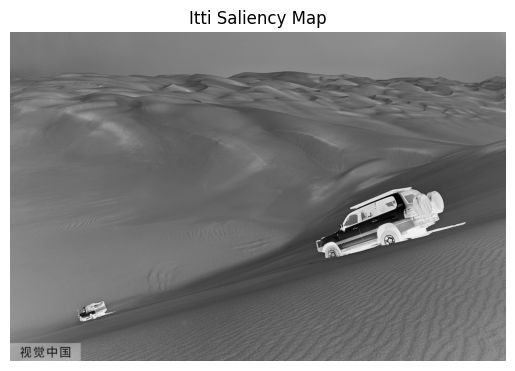

In [3]:
# 计算亮度特征  
intensity_feature = gray  

# 计算颜色特征（这里只考虑了RGB颜色空间，实际应用中可能需要更复杂的颜色空间转换）  
color_feature = cv2.pyrMeanShiftFiltering(image, sp=10, sr=50, maxLevel=2)  
color_feature = cv2.cvtColor(color_feature, cv2.COLOR_BGR2GRAY)  

# 计算方向特征（这里使用Sobel算子来近似方向特征）  
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)  
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)  
orientation_feature = np.sqrt(sobelx**2 + sobely**2)

# 对特征进行归一化  
intensity_feature = cv2.normalize(intensity_feature, None, alpha=0, beta=100, norm_type=cv2.NORM_MINMAX)  
color_feature = cv2.normalize(color_feature, None, alpha=0, beta=100, norm_type=cv2.NORM_MINMAX)  
orientation_feature = cv2.normalize(orientation_feature, None, alpha=0, beta=100, norm_type=cv2.NORM_MINMAX)  

# 合并特征  
saliency_map = cv2.addWeighted(intensity_feature, 0, color_feature, 0.0, 0.0,dtype = cv2.CV_32F)  
saliency_map = cv2.addWeighted(saliency_map, 0, orientation_feature, 0, 0.0,dtype = cv2.CV_32F)  

# 应用高斯模糊来平滑显著性图  
saliency_map = cv2.GaussianBlur(saliency_map, (5, 5), 0)  
resu = saliency_map - gray
# 归一化显著性图到0-255范围，以便显示  
Itti_saliency_map = cv2.normalize(resu, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(Itti_saliency_map, cmap='gray')  # 使用灰度色图显示显著性图  
plt.axis('off')  # 关闭坐标轴显示  
plt.title('Itti Saliency Map')  # 设置标题  
plt.show()  # 显示图像

# **残差谱SR算法**

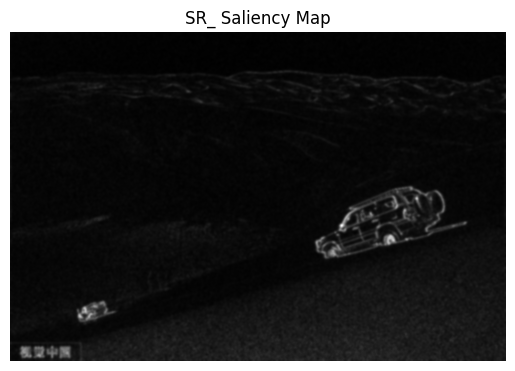

In [4]:
#傅里叶变换
fft = np.fft.fft2(gray)
fshift = np.fft.fftshift(fft)

#计算幅度值与相位值
LogAmp = np.log(np.abs(fshift))
phase =np.angle(fshift)

#计算谱残差值
BlurAmp = cv2.blur(LogAmp, (3,3)) #均值谱
Spectral_res = LogAmp - BlurAmp

#傅里叶反变换计算显著图
ishift = np.fft.ifftshift(np.exp(Spectral_res+1j*phase))
Res_ifft = np.fft.ifft2(ishift)
Res = np.abs(Res_ifft)

#高斯滤波 显示结果
saliency_map = cv2.GaussianBlur(Res, (15,15), 2)
#print(saliency_map)



# 显示原始图像和显著性图  
plt.imshow(saliency_map, cmap='gray')  # 使用灰度色图显示显著性图  
plt.axis('off')  # 关闭坐标轴显示  
plt.title('SR_ Saliency Map')  # 设置标题  
plt.show()  # 显示图像

# **FT算法**

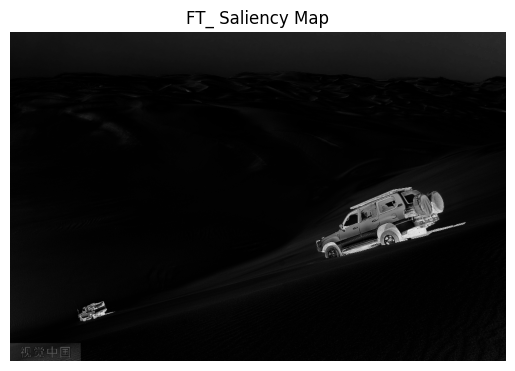

In [5]:
l_mean = np.mean(gray_lab[:,:,0])
a_mean = np.mean(gray_lab[:,:,1])
b_mean = np.mean(gray_lab[:,:,2])
lab = np.square(gray_lab- np.array([l_mean, a_mean, b_mean]))
lab = np.sum(lab,axis=2)
lab = lab/np.max(lab)

# 显示原始图像和显著性图  
plt.imshow(lab, cmap='gray')  # 使用灰度色图显示显著性图  
plt.axis('off')  # 关闭坐标轴显示  
plt.title('FT_ Saliency Map')  # 设置标题  
plt.show()  # 显示图像

# **CA算法**

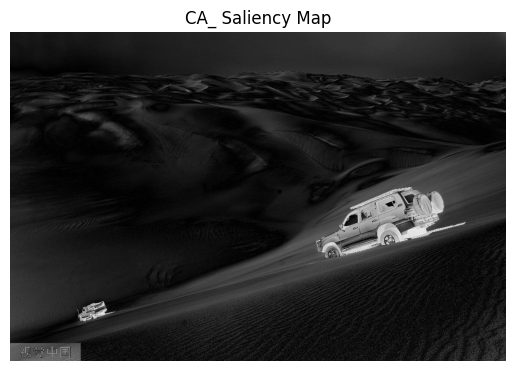

In [6]:
# 计算图像的均值  
mean_gray = np.mean(gray)  

# 计算每个像素与均值的差异（对比度）  
contrast = np.abs(gray - mean_gray)  

# 对对比度进行归一化  
contrast_normalized = (contrast - np.min(contrast)) / (np.max(contrast) - np.min(contrast))  

# 将归一化后的对比度转换为8位图像  
CA_saliency_map = (contrast_normalized * 255).astype("uint8")

# 显示原始图像和显著性图  
plt.imshow(CA_saliency_map, cmap='gray')  # 使用灰度色图显示显著性图  
plt.axis('off')  # 关闭坐标轴显示  
plt.title('CA_ Saliency Map')  # 设置标题  
plt.show()  # 显示图像

# **HC算法**

bincount_pallet: 1728
Quantize time is : 0.6664505004882812 seconds


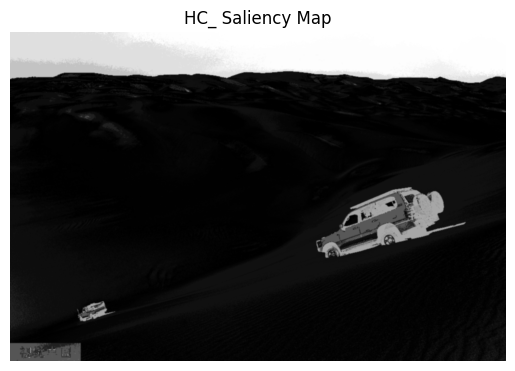

In [36]:
def Quantize(img3f,ratio=0.95,colorNums=(12,12,12)):
    clrTmp = [colorNums[0]-0.0001, colorNums[1]-0.0001, colorNums[2]-0.0001]
    w = [colorNums[1] * colorNums[2], colorNums[2], 1]

    height,width = img3f.shape[:2]
    img3f_0,img3f_1,img3f_2 = cv2.split(img3f)

    idx_img3f_0 = (img3f_0 * clrTmp[0] ).astype(np.int32)* w[0]
    idx_img3f_1 = (img3f_1 * clrTmp[1] ).astype(np.int32)* w[1]
    idx_img3f_2 = (img3f_2 * clrTmp[2] ).astype(np.int32)* w[2]
    idx1i = idx_img3f_0 + idx_img3f_1 + idx_img3f_2

    #==================== 统计像素出现频数 ======================
    bincount_pallet = np.bincount(idx1i.reshape(1,-1)[0])
    print('bincount_pallet:',len(bincount_pallet))
    sort_pallet = np.sort(bincount_pallet)
    argsort_pallet = np.argsort(bincount_pallet)
    numpy_pallet = np.vstack((sort_pallet, argsort_pallet))
    numpy_pallet = numpy_pallet[:, np.nonzero(sort_pallet)]

    num = np.swapaxes(numpy_pallet, 0, 1)[0]                      # 维度交换
    len_num = maxNum = len(num[0])                                # 所有颜色值出现频数的排序（从小到大）

    maxDropNum = int(np.round(height * width * (1 - ratio)))      # 设置删除最大元素阈值
    sum_pallet = np.add.accumulate(num[0])
    arg_sum_pallett = np.argwhere(sum_pallet >= maxDropNum)[0][0] # 前95%的颜色值数量
    maxNum = maxNum - arg_sum_pallett                             # 后5%的颜色值数量
    num_values = num[1][::-1]                                     # 所有高频次颜色值的位置（颜色值降序）

    maxNum = 256 if maxNum > 256 else maxNum
    if maxNum <= 10:
        maxNum = 10 if len(num) > 10 else len(num)

    color3i_init0 = (num_values / w[0]).astype(np.int32)
    color3i_init1 = (num_values % w[0]/w[1]).astype(np.int32)
    color3i_init2 = (num_values % w[1]).astype(np.int32)
    color3i = np.array([color3i_init0,color3i_init1,color3i_init2]).T


    #=========================计算像素距离==============================
    zero2maxNum = color3i[:maxNum]                  #  5%的颜色值数量部分
    maxNum2len_Num = color3i[maxNum:]               # 95%的颜色值数量部分
    temp_matrix = np.zeros((len_num-maxNum,maxNum),dtype=np.int32)

    for i,single in enumerate(maxNum2len_Num):      #分别求：95%的颜色值与5%的颜色值的距离
        temp_matrix[i] = np.sum(np.square(single-zero2maxNum),axis=1)

    arg_min = np.argmin(temp_matrix, axis=1)
    replaceable_colors = num_values[arg_min]       # 通过索引获取5%的颜色值中距离95%的颜色值最近的颜色值

    pallet = dict(zip(num_values[:maxNum], range(maxNum)))
    for num_value,index_dist in zip(num_values[maxNum:],replaceable_colors):
        pallet[num_value] = pallet[index_dist]
    #=================================================================
    idx1i_reshape = idx1i.copy().reshape(1,-1)[0]
    idx1i_0 = np.zeros(height * width, dtype=np.int32)
    for i, v in enumerate(idx1i_reshape):
        idx1i_0[i] = pallet[v]
    idx1i = idx1i_0.reshape((height,width))
    color3f = np.zeros((1, maxNum, 3), np.float32)
    colorNum = np.zeros((1, maxNum), np.int32)
    np.add.at(color3f[0], idx1i, img3f)
    np.add.at(colorNum[0], idx1i, 1)
    colorNum_reshape = colorNum.reshape(color3f.shape[1],1)
    color3f[0] /= colorNum_reshape
    
    return color3f.shape[1],idx1i,color3f,colorNum

import cv2, time
import numpy as np
from scipy.spatial.distance import pdist, squareform


def GetHC(img_float,delta=0.25):
    t1 = time.time()
    binN, idx1i, binColor3f, colorNums1i = Quantize(img_float)                 # 颜色量化
    t2 = time.time()
    print("Quantize time is :", t2 - t1, 'seconds')
    binColor3f = cv2.cvtColor(binColor3f, cv2.COLOR_BGR2Lab)                   # 颜色空间：BGR2Lab
    weight1f = np.zeros(colorNums1i.shape, np.float32)
    cv2.normalize(colorNums1i.astype(np.float32), weight1f, 1, 0, cv2.NORM_L1) # 相邻色彩相关权重

    binColor3f_reshape = binColor3f.reshape(-1, 3)[:binN]
    similar_dist = squareform(pdist(binColor3f_reshape))
    similar_dist_sort = np.sort(similar_dist)
    similar_dist_argsort = np.argsort(similar_dist)

    weight1f = np.tile(weight1f, (binN, 1))
    color_weight_dist = np.sum(np.multiply(weight1f, similar_dist), axis=1)    # 颜色距离的权重分配

    colorSal = np.zeros((1, binN), np.float64)
    if colorSal.shape[1] < 2:
        return
    tmpNum = int(np.round(binN * delta))                                       # tmpNum 占比0.25的变化的颜色值数量
    n = tmpNum if tmpNum > 2 else 2

    similar_nVal = similar_dist_sort[:, :n]
    totalDist_similar = np.sum(similar_nVal, axis=1)
    every_Dist = np.tile(totalDist_similar[:, np.newaxis], (1, n)) - similar_nVal

    idx = similar_dist_argsort[:, :n]
    val_n = np.take(color_weight_dist,idx)                                    # 获取占比前0.25的颜色权重距离

    valCrnt = np.sum(val_n[:, :n] * every_Dist, axis=1)
    newSal_img = valCrnt / (totalDist_similar * n)
    cv2.normalize(newSal_img, newSal_img, 0, 1, cv2.NORM_MINMAX)              # 归一化
    salHC_img = np.take(newSal_img,idx1i)
    cv2.GaussianBlur(salHC_img, (3, 3), 0, salHC_img)
    cv2.normalize(salHC_img, salHC_img, 0, 1, cv2.NORM_MINMAX)
    return salHC_img


if __name__ == "__main__":
    
    img_float = image.astype(np.float32)
    img_float = img_float / 255.0
    sal = GetHC(img3_float)

    # 显示原始图像和显著性图  
    plt.imshow(sal, cmap='gray')  # 使用灰度色图显示显著性图  
    plt.axis('off')  # 关闭坐标轴显示  
    plt.title('HC_ Saliency Map')  # 设置标题  
    plt.show()  # 显示图像
  

# **LC算法**

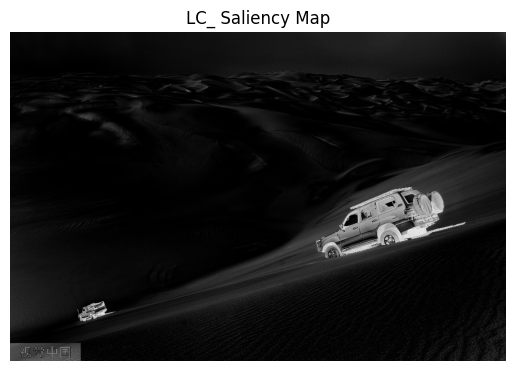

In [38]:

def diag_sym_matrix(k=256):
    base_matrix = np.zeros((k,k))
    base_line = np.array(range(k))
    base_matrix[0] = base_line
    for i in range(1,k):
        base_matrix[i] = np.roll(base_line,i)
    base_matrix_triu = np.triu(base_matrix)
    return base_matrix_triu + base_matrix_triu.T

def cal_dist(hist):
    Diag_sym = diag_sym_matrix(k=256)
    hist_reshape = hist.reshape(1,-1)
    hist_reshape = np.tile(hist_reshape, (256, 1))
    return np.sum(Diag_sym*hist_reshape,axis=1)

def LC(image_gray):
    image_height,image_width = image_gray.shape[:2]
    hist_array = cv2.calcHist([image_gray], [0], None, [256], [0.0, 256.0])
    gray_dist = cal_dist(hist_array)

    image_gray_value = image_gray.reshape(1,-1)[0]
    image_gray_copy = [(lambda x: gray_dist[x]) (x)  for x in image_gray_value]
    image_gray_copy = np.array(image_gray_copy).reshape(image_height,image_width)
    image_gray_copy = (image_gray_copy-np.min(image_gray_copy))/(np.max(image_gray_copy)-np.min(image_gray_copy))
    return image_gray_copy


if __name__ == '__main__':
    
    LC_saliency_image = LC(gray)
    
    # 显示原始图像和显著性图  
    plt.imshow(LC_saliency_image, cmap='gray')  # 使用灰度色图显示显著性图  
    plt.axis('off')  # 关闭坐标轴显示  
    plt.title('LC_ Saliency Map')  # 设置标题  
    plt.show()  # 显示图像
